# DS-SF-38 | 11 | Regularization | Codealong | Answer Key

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from sklearn import preprocessing, linear_model, model_selection, metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Truth

In [2]:
def f(x):
    return np.sin(2 * np.pi * x)

In [3]:
truth_df = pd.DataFrame(index = range(100))
truth_df['x'] = np.linspace(0, 1, truth_df.shape[0])
truth_df['y'] = truth_df.x.apply(f)

### Training/testing sets

- (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [4]:
np.random.seed(0)

df = pd.DataFrame(index = range(100))
df['x'] = np.random.uniform(0, 1, size = df.shape[0])

df['Noise'] = np.random.normal(size = df.shape[0])
df['y'] = df.x.apply(f) * (1 + .5 * df.Noise)

In [5]:
X = df[ ['x'] ]
y = df.y

In [6]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, train_size = .25)

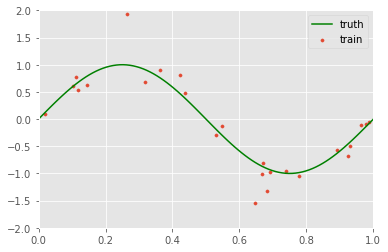

In [7]:
plt.figure()
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

plt.legend()

### Polynomial Models

- (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [8]:
class Polynomial(object):
    def __init__(self, n):
        self.features = preprocessing.PolynomialFeatures(n)
        self.model = linear_model.LinearRegression()

    def fit(self, X, y):
        self.X = X
        self.features.fit(X)

        X = self.features.transform(X)
        self.model.fit(X, y)

        return self

    def predict(self, X):
        X = self.features.transform(X)
        return self.model.predict(X)

    def score(self, X, y):
        X = self.features.transform(X)
        return self.model.score(X, y)

    def mean_squared_error(self, X, y):
        y_hat = self.predict(X)
        return metrics.mean_squared_error(y, y_hat)

In [9]:
ns = [0, 1, 2, 3, 5, 7, 11, 13, 17, 19]

models = pd.Series([Polynomial(n).fit(train_X, train_y) for n in ns], index = ns)

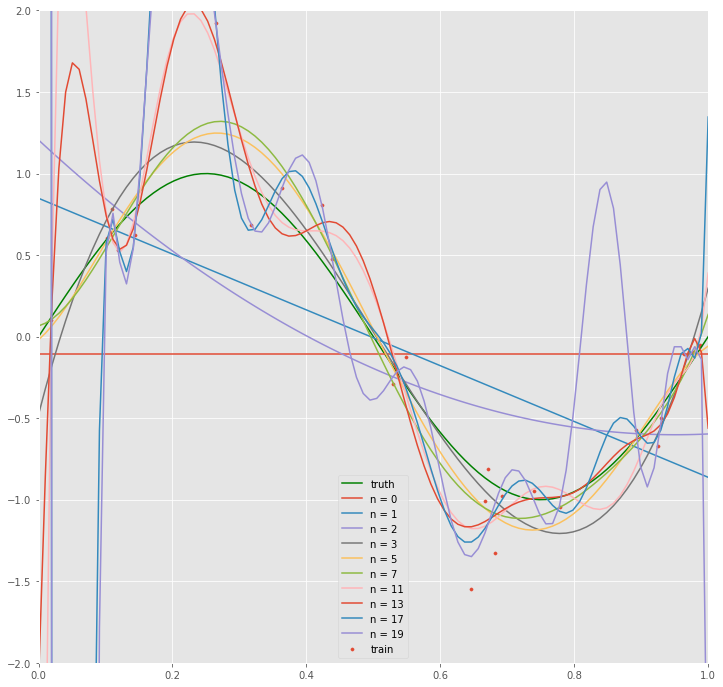

In [10]:
plt.figure(figsize = (12, 12))
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

for n in ns:
    X = truth_df[ ['x'] ]
    y_hat = models[n].predict(X)
    plt.plot(X.x, y_hat, label = 'n = {}'.format(n))

plt.legend()

### $R^2$

In [11]:
metrics_df = pd.DataFrame(index = models.index)

metrics_df['R^2 (train)'] = models.apply(lambda model: model.score(train_X, train_y))
metrics_df['R^2 (test)'] = models.apply(lambda model: model.score(test_X, test_y))

metrics_df

,R^2 (train),R^2 (test)
0,0.000000,-0.047832
1,0.397731,0.474226
2,0.435834,0.434698
3,0.884829,0.791700
5,0.910461,0.811343
7,0.914797,0.804236
11,0.948775,-0.319321
13,0.954992,0.512531
17,0.977433,-607.190450
19,0.982301,-12059.448348


### Bias-Variance Trade-off

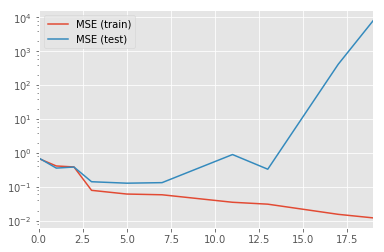

In [12]:
metrics_df = pd.DataFrame(index = models.index)

metrics_df['MSE (train)'] = models.apply(lambda model: model.mean_squared_error(train_X, train_y))
metrics_df['MSE (test)'] = models.apply(lambda model: model.mean_squared_error(test_X, test_y))

metrics_df.plot(logy = True)

### Regularization

- (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

#### Ridge

In [13]:
n = 19
alphas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-11, 1e-13, 1e-17, 1e-19]

In [14]:
class PolynomialRidge(object):

    @staticmethod
    def coefficients_names(n):
        return map(lambda i: 'beta_{}'.format(i), range(n + 1))

    def __init__(self, alpha, n):
        self.alpha = alpha
        self.n = n

        self.features = preprocessing.PolynomialFeatures(self.n)
        self.model = linear_model.Ridge(self.alpha)

    def fit(self, X, y):
        self.X = X
        self.features.fit(X)

        X = self.features.transform(X)
        self.model.fit(X, y)

        self.coefficients = pd.Series(self.model.coef_, index = self.__class__.coefficients_names(self.n))
        self.complexity = (self.coefficients ** 2).sum() ** .5

        return self

    def predict(self, X):
        X = self.features.transform(X)
        return self.model.predict(X)

    def score(self, X, y):
        X = self.features.transform(X)
        return self.model.score(X, y)

    def mean_squared_error(self, X, y):
        y_hat = self.predict(X)
        return metrics.mean_squared_error(y, y_hat)

In [15]:
models = pd.Series([PolynomialRidge(alpha, n).fit(train_X, train_y) for alpha in alphas], index = alphas)

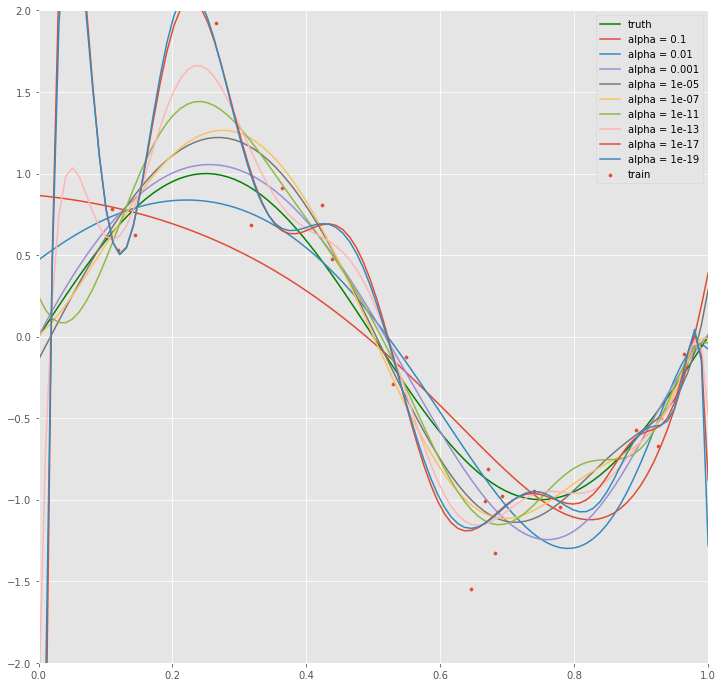

In [16]:
plt.figure(figsize = (12, 12))
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

for alpha in alphas:
    X = truth_df[ ['x'] ]
    y_hat = models[alpha].predict(X)
    plt.plot(X.x, y_hat, label = 'alpha = {}'.format(alpha))

plt.legend()

In [17]:
metrics_df = pd.DataFrame(index = models.index)

metrics_df['R^2 (train)'] = models.apply(lambda model: model.score(train_X, train_y))
metrics_df['R^2 (test)'] = models.apply(lambda model: model.score(test_X, test_y))
metrics_df['Complexity'] = models.apply(lambda model: model.complexity)

metrics_df

,R^2 (train),R^2 (test),Complexity
1.000000e-01,0.717354,0.654047,3.079266e+00
1.000000e-02,0.837731,0.752940,9.175317e+00
1.000000e-03,0.893328,0.809549,2.033640e+01
1.000000e-05,0.913066,0.815893,6.642811e+01
1.000000e-07,0.916742,0.809700,2.989853e+02
1.000000e-11,0.924521,0.784969,3.646325e+04
1.000000e-13,0.945703,0.683161,1.117806e+06
1.000000e-17,0.955086,-0.286029,1.128423e+07
1.000000e-19,0.955706,-0.013533,2.029244e+08


In [18]:
coefficients_df = pd.DataFrame(columns = PolynomialRidge.coefficients_names(n))

for alpha in alphas:
    model = models[alpha]
    coefficients_df.loc[model.complexity, :] = model.coefficients

In [19]:
coefficients_df

,beta_0,beta_1,beta_2,beta_3,beta_4,...,beta_15,beta_16,beta_17,beta_18,beta_19
3.079266e+00,0,-0.414271,-1.94637,-1.47671,-0.658799,...,0.076565,-0.0354665,-0.140019,-0.236624,-0.325247
9.175317e+00,0,3.09875,-5.5072,-4.23648,-1.35286,...,-0.481713,-0.711546,-0.895723,-1.0401,-1.15048
2.033640e+01,0,7.89021,-13.0775,-7.35615,0.917024,...,-1.58963,-0.786509,0.168698,1.21857,2.3169
6.642811e+01,0,7.92121,-0.631679,-40.1051,1.74871,...,9.54904,11.37,8.97342,1.73574,-10.6737
2.989853e+02,0,3.51802,33.1106,-138.083,112.273,...,45.3973,92.0054,95.4893,29.4338,-128.252
3.646325e+04,0,-9.25144,127.891,234.359,-5143.62,...,6015.52,-1185.07,-6266.25,-4102.92,4337.95
1.117806e+06,0,187.015,-3838.04,36033.2,-173722,...,-193549,-301624,-4197.91,376698,-166956
1.128423e+07,0,686.165,-15148.2,155908,-876126,...,2.66379e+06,-754976,-2.63146e+06,2.41564e+06,-642679
2.029244e+08,0,497.506,-9071.08,56665.4,81862.9,...,3.24256e+07,-4.71975e+07,9.71078e+06,7.6237e+06,-3.04405e+06


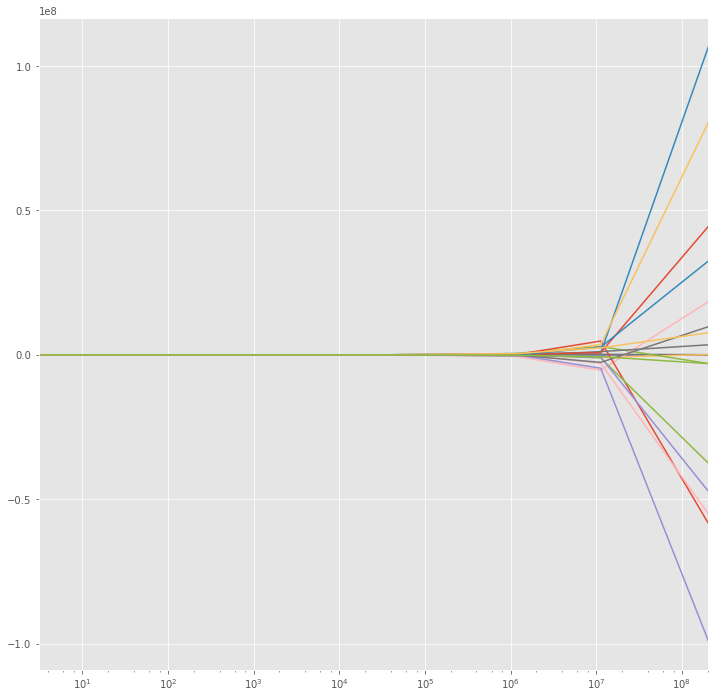

In [20]:
coefficients_df.plot(logx = True, legend = False, figsize = (12, 12))

#### Lasso

In [21]:
class PolynomialLasso(object):

    @staticmethod
    def coefficients_names(n):
        return map(lambda i: 'beta_{}'.format(i), range(n + 1))

    def __init__(self, alpha, n):
        self.alpha = alpha
        self.n = n

        self.features = preprocessing.PolynomialFeatures(self.n)
        self.model = linear_model.Lasso(self.alpha)

    def fit(self, X, y):
        self.X = X
        self.features.fit(X)

        X = self.features.transform(X)
        self.model.fit(X, y)

        self.coefficients = pd.Series(self.model.coef_, index = self.__class__.coefficients_names(self.n))
        self.complexity = (self.coefficients ** 2).sum() ** .5

        return self

    def predict(self, X):
        X = self.features.transform(X)
        return self.model.predict(X)

    def score(self, X, y):
        X = self.features.transform(X)
        return self.model.score(X, y)

    def mean_squared_error(self, X, y):
        y_hat = self.predict(X)
        return metrics.mean_squared_error(y, y_hat)

In [22]:
models = pd.Series([PolynomialLasso(alpha, n).fit(train_X, train_y) for alpha in alphas], index = alphas)

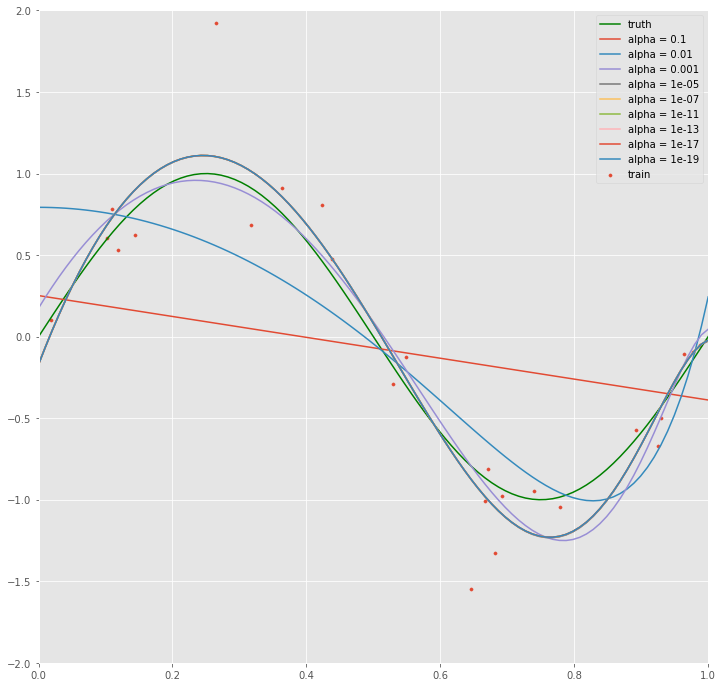

In [23]:
plt.figure(figsize = (12, 12))
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

for alpha in alphas:
    X = truth_df[ ['x'] ]
    y_hat = models[alpha].predict(X)
    plt.plot(X.x, y_hat, label = 'alpha = {}'.format(alpha))

plt.legend()

In [24]:
metrics_df = pd.DataFrame(index = models.index)

metrics_df['R^2 (train)'] = models.apply(lambda model: model.score(train_X, train_y))
metrics_df['R^2 (test)'] = models.apply(lambda model: model.score(test_X, test_y))
metrics_df['Complexity'] = models.apply(lambda model: model.complexity)

metrics_df

,R^2 (train),R^2 (test),Complexity
1.000000e-01,0.241983,0.237192,0.640214
1.000000e-02,0.701186,0.651788,4.280558
1.000000e-03,0.869997,0.789245,17.010396
1.000000e-05,0.895063,0.808142,26.313361
1.000000e-07,0.895267,0.808415,26.472341
1.000000e-11,0.895270,0.808418,26.473963
1.000000e-13,0.895270,0.808418,26.473963
1.000000e-17,0.895270,0.808418,26.473963
1.000000e-19,0.895270,0.808418,26.473963


In [25]:
coefficients_df = pd.DataFrame(columns = PolynomialRidge.coefficients_names(n))

for alpha in alphas:
    model = models[alpha]
    coefficients_df.loc[model.complexity, :] = model.coefficients

In [26]:
coefficients_df

,beta_0,beta_1,beta_2,beta_3,beta_4,...,beta_15,beta_16,beta_17,beta_18,beta_19
0.640214,0,-0.640214,-0,-0,-0,...,0,0,0,0,0
4.280558,0,-0,-3.369,-0,0,...,0,0,0,0,0
17.010396,0,6.71503,-14.4386,-0,0,...,-0,-0,-0,-0,-1.5908
26.313361,0,10.6382,-22.6039,0.227715,5.4054,...,-0.361928,-0.218707,-0.0828737,0.0152524,0.09292
26.472341,0,10.6818,-22.7299,0.241856,5.54148,...,-0.357968,-0.215555,-0.0803782,0.0419796,0.149278
26.473963,0,10.6822,-22.7311,0.241977,5.54288,...,-0.357934,-0.215529,-0.0803589,0.0422766,0.149862
26.473963,0,10.6822,-22.7311,0.241977,5.54288,...,-0.357934,-0.215529,-0.0803589,0.0422767,0.149862
26.473963,0,10.6822,-22.7311,0.241977,5.54288,...,-0.357934,-0.215529,-0.0803589,0.0422767,0.149862
26.473963,0,10.6822,-22.7311,0.241977,5.54288,...,-0.357934,-0.215529,-0.0803589,0.0422767,0.149862


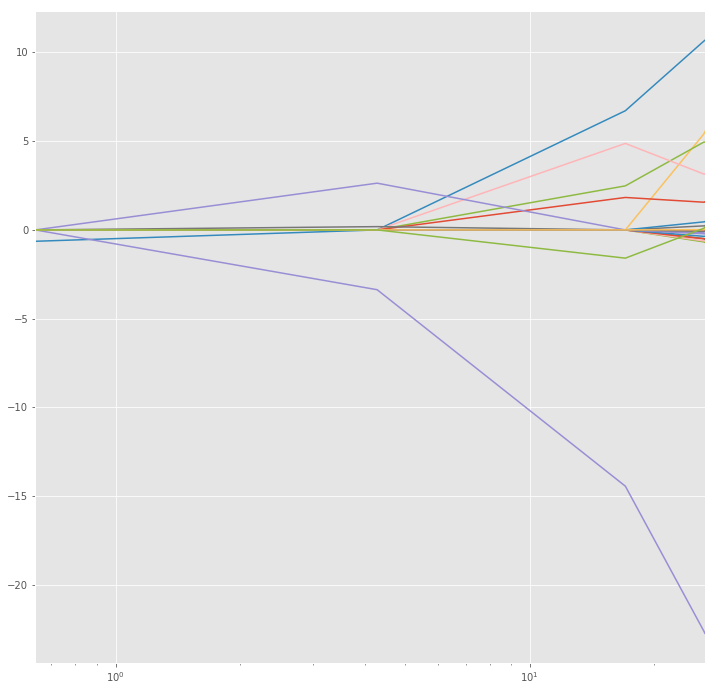

In [27]:
coefficients_df.plot(logx = True, legend = False, figsize = (12, 12))